# Push BDL

## Introduction

In this notebook, we introduce Bayesian Deep Learning (BDL) and demonstrate how to use Push to perform BDL by running a deep ensemble. Bayesian Deep Learning methods seek to describe a model through distributions instead of point estimates. We want to know the distribution of possible parameter settings or predictions for a given dataset, so that we can derive new metrics like uncertainty. For example, by training 16 different models on the same dataset we obtain 16 unique parameter settings. If we make a prediction on with each model, we obtain a distribution of 16 different predictions. If we define uncertainty to be the variance in prediction results, we can quantify uncertainty based on the how much our predictions vary for a given input. This is a fundamental goal of Bayesian Deep Learning methods, as in the real world we often encounter data that is very different from our training data. In instances where our models is seeing new data that is very dissimilar from its training set, we would like to be informed that the model is less certain about its prediction. Consequently for data that is very similar to the training set, we would expect to see uncertainty be low.

## Background

### The Posterior Distribution

The main goal of BDL methods is to quantify uncertainty through the computation of the *posterior predictive distribution*. The posterior represents our hypothesis for the distribution of values each parameter can take. In classical machine learning algorithims, we seek to produce a *point-estimate*, which optimizes a single parameter setting to compute one output given one input. In BDL, we are interested in finding a distribution of parameter settings so that we can produce a distribution of predictions for each individual input. This distribution of predictions is called the *predictive distribution*. Thus we can quantify uncertainty through the variance in our predictive distribution for a given input. A prediction with high variance would be highly uncertain, while a prediction with low variance would have a high degree of certainty.

In order to compute the posterior distribution, we must use Bayes Theorem.


$$
posterior = \frac{likelihood * prior}{evidence}, or 

P(\theta|D) = \frac{P(D|\theta) \cdot P(\theta)}{P(D)}
$$

### Prior
The prior, $P(\theta)$, represents our belief for distribution of parameter settings before seeing any data. As we train, we update the posterior by multipying our prior belief with the likelihood, $P(D|\theta)$. In convential neural networks, we optimize a setting of parameters through some form of gradient descent to obtain a Maximum Likelihood Estimation $P(D|\theta)$. This is the same likelihood used in bayesian approaches and tells us how well our model fits our dataset. 

### The Posterior Predictive Distribution

We marginalize the posterior, $P(\theta|D)$ over all possible parameter settings to obtain the predictive distribution which can produce uncertainty quantifications by measuring the variance of prediction values for a partical input. 




$$
p(y|x, \mathcal{D}) = \int p(y|x, \theta) p(\theta | \mathcal{D}) \, d\theta
$$
where $y$ is an output, $x$ is an input, $\theta$ are parameters, and $\mathcal{D} = (x_i, y_i)_{i}$ is a dataset. In general, this integral is intractable and must be approximated. It almost always impossible for us to marginalize over every single possible parameter setting in the parameter space, so we must turn to methods such as Monte Carlo Approximation to approximate the marginalized posterior.

### Monte Carlo Approximation

We can approximate the posterior predictive distribution with a Monte Carlo approximation [1]: 
$$
p(y|x, \mathcal{D}) \approx \frac{1}{J} \sum_{j=1}^{J} p(y|x, \theta_j), \quad \theta_j \sim p(\theta | D)
$$
where each $\theta_j$ corresponds to a unique parameter setting.

### Deep Ensembles

#### Prior
 *Deep ensembles* train $J$ different initializations of the same neural network (NN). We do not explicity define a prior for deep ensembles, but the network architecture and random initialization of the model's parameters serve as an implicit prior.
#### Likelihood
Each network updates its parameter settings independently through some variation of gradient descent, maximizing the *likelihood* $P(D|\theta)$. This likelihood is a measure for how well a model fits the data, and gradient descent updates the parameters $\theta$ to maximize the probability of our model fitting the observed data. The updating of parameters through gradient descent serves as an update to our *prior* belief about the initial parameter settings. 

#### Posterior Distribution
Once we train $J$ different networks on our data, we obtain, ${\theta_{1},...\theta_{j}}$ parameter settings. This serves as our posterior distribution, $P(\theta|D)$.

#### Posterior Predictive Distribution
For a given datapoint, we can obtain the prediction from each of our $J$ models. This will produce ${y_1,...,y_j}$ prediction values, which serves as our posterior predictive distribution. If we average our prediction results, $p(y | x, \theta_j)$, over $J$ settings of $\theta_j$, we are essentially performing a Monte Carlo estimate that approximates the posterior predictive distribution. Thus, deep ensembles form a simple BDL method.

## Deep Ensembles in Push

We will now introduce deep ensembles in Push. Push interoperates with PyTorch, and so all datasets and models can use PyTorch components. Push also has concurrent execution semantics.

### Dataset

For illustrative purposes, we create a random dataset with $N$ points of dimension $D$.

In [1]:
from bdl import SineDataset
import math

D = 1
batch_size = 12
N = 64
train_begin_radians = -2 * math.pi
train_end_radians = 2 * math.pi
test_begin_radians = -4 * math.pi
test_end_radians = 4 * math.pi
dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)
oos_dataset = SineDataset(batch_size, N, D, test_begin_radians, test_end_radians)

```py
class SineDataset(Dataset):
    def __init__(self, batch_size, N, D, begin, end):
        self.xs = torch.linspace(begin * math.pi, end * math.pi, batch_size * N * D).reshape(batch_size * N, D)
        self.ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

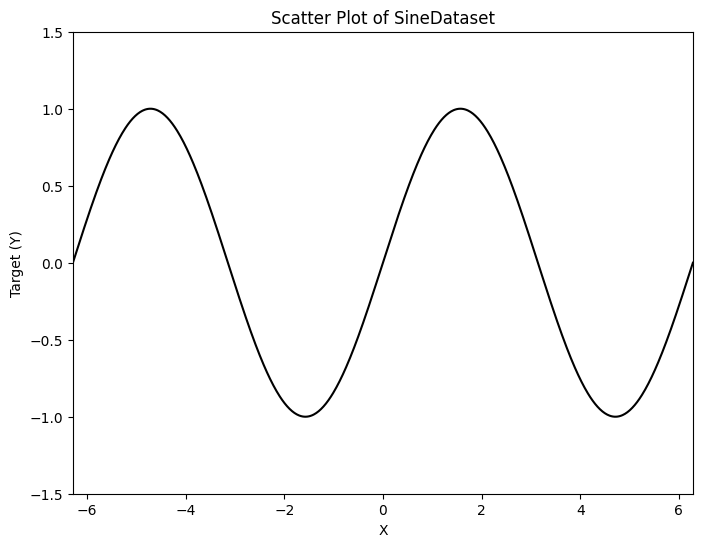

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

### Varying number of datapoints

In [3]:

# D = 1
# batch_size = 12
# train_begin_radians = -2 * math.pi
# train_end_radians = 2 * math.pi

# # 12 total datapoints
# N = 1
# twelve_dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)

# # 48 total datapoints
# N = 4
# foureight_dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)

# # 192 total datapoints
# N = 16
# oneninetwo_dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)

# # 768 total datapoints
# N = 64
# sevensixeight_dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)

# # 3072 total datapoints
# N = 256
# large_dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)




### Neural Network

We create a simple neural network (NN). This NN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. 

In [4]:
from bdl import MiniNN
from bdl import BiggerNN

```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
```

### Training a Standard Neural Network (num_ensemble = 1)


### Varying number of Datapoints

In [5]:
# import torch
# from torch.utils.data import DataLoader
# import push.bayes.ensemble



# epochs = 100
# num_ensembles = 1
# n = 2
# input_dim = 1
# output_dim = 1
# hidden_dim = 64


# dataloader = DataLoader(twelve_dataset, batch_size=batch_size, shuffle=True)
# twelvedata_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# twelvedata_standard_params = twelvedata_standard_params[0]

# dataloader = DataLoader(foureight_dataset, batch_size=batch_size, shuffle=True)
# foureightdata_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# foureightdata_standard_params = foureightdata_standard_params[0]

# dataloader = DataLoader(oneninetwo_dataset, batch_size=batch_size, shuffle=True)
# oneninetwodata_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# oneninetwodata_standard_params = oneninetwodata_standard_params[0]

# dataloader = DataLoader(sevensixeight_dataset, batch_size=batch_size, shuffle=True)
# sevensixeightdata_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# sevensixeightdata_standard_params = sevensixeightdata_standard_params[0]

# dataloader = DataLoader(large_dataset, batch_size=batch_size, shuffle=True)
# large_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# large_standard_params = large_standard_params[0]





In [6]:
# def get_model_output(params, dataset, n, input_dim, output_dim, hidden_dim):
#     model = BiggerNN(n, input_dim, output_dim, hidden_dim)
#     # Check if the number of parameters in the list matches the number of model parameters
#     if len(params) != len(list(model.parameters())):
#         print("The number of parameters in the list does not match the number of model parameters.")
#     else:
#         # Iterate through the model parameters and assign values from the list
#         for model_param, param_value in zip(model.parameters(), params):
#             model_param.data = param_value

#     model_outputs = []
#     for xs in dataset.xs:
#         model_outputs.append(model(xs).detach())
#     return model_outputs



# twelvedata_model_outputs = get_model_output(twelvedata_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# foureightdata_model_outputss = get_model_output(foureightdata_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# oneninetwodata_model_outputs = get_model_output(oneninetwodata_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# sevensixeightdata_model_outputs = get_model_output(sevensixeightdata_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# large_model_outputs = get_model_output(large_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
    

# # Extract the data
# xs = dataset.xs
# ys = dataset.ys

# # Plot the data without a colorbar
# plt.figure(figsize=(8, 6))
# plt.plot(xs, ys, c="black", label= "Ground Truth")
# plt.plot(xs, twelvedata_model_outputs, c="red", label="12 Datapoints")
# plt.plot(xs, foureightdata_model_outputss, c="blue", label="48 Datapoints")
# plt.plot(xs, oneninetwodata_model_outputs, c="green", label="192 Datapoints")
# plt.plot(xs, sevensixeightdata_model_outputs, c="yellow", label="768 Datapoints")
# plt.plot(xs, large_model_outputs, c="orange", label="3072 Datapoints")


# plt.title('Scatter Plot of Sine Dataset, Single Model')
# plt.xlabel('X')
# plt.ylabel('Target (Y)')
# plt.legend()
# plt.show()


### Hyperparameter selection
Before training our model, there are a some hyperparameters we must set. The number of layers (**n**) and hidden dimensions (**hidden_dim**) are the most consequential. In the cell below we show the effect of increasing the number hidden dimensions. Hidden dimensions refers to the number of nodes in each fully connected layer defined in MiniNN. BiggerNN is composed of n MiniNNs, with an input layer preceeding and an ouput layer after.

### Varying Hidden Dimensions

In [7]:
# import torch
# from torch.utils.data import DataLoader
# import push.bayes.ensemble

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# epochs = 100
# num_ensembles = 1
# n = 2
# input_dim = 1
# output_dim = 1

# hidden_dim = 16
# sixteendim_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# sixteendim_standard_params = sixteendim_standard_params[0]


# hidden_dim = 32
# thirtytwodim_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# thirtytwodim_standard_params = thirtytwodim_standard_params[0]


# hidden_dim = 64
# sixtyfourdim_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# sixtyfourdim_standard_params = sixtyfourdim_standard_params[0]


# hidden_dim = 128
# onetwoeightdim_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# onetwoeightdim_standard_params = onetwoeightdim_standard_params[0]


In [8]:
# def get_model_output(params, dataset, n, input_dim, output_dim, hidden_dim):
#     model = BiggerNN(n, input_dim, output_dim, hidden_dim)
#     # Check if the number of parameters in the list matches the number of model parameters
#     if len(params) != len(list(model.parameters())):
#         print("The number of parameters in the list does not match the number of model parameters.")
#     else:
#         # Iterate through the model parameters and assign values from the list
#         for model_param, param_value in zip(model.parameters(), params):
#             model_param.data = param_value

#     model_outputs = []
#     for xs in dataset.xs:
#         model_outputs.append(model(xs).detach())
#     return model_outputs



# sixteendim_model_outputs = get_model_output(sixteendim_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=16)
# thirtytwodim_model_outputss = get_model_output(thirtytwodim_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=32)
# sixtyfourdim_model_outputs = get_model_output(sixtyfourdim_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# onetwoeightdim_model_outputs = get_model_output(onetwoeightdim_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=128)
    

# # Extract the data
# xs = dataset.xs
# ys = dataset.ys

# # Plot the data without a colorbar
# plt.figure(figsize=(8, 6))
# plt.plot(xs, ys, c="black", label= "Ground Truth")
# plt.plot(xs, sixteendim_model_outputs, c="red", label="16 Hidden Dimensions")
# plt.plot(xs, thirtytwodim_model_outputss, c="blue", label="32 Hidden Dimensions")
# plt.plot(xs, sixtyfourdim_model_outputs, c="green", label="64 Hidden Dimensions")
# plt.plot(xs, onetwoeightdim_model_outputs, c="yellow", label="128 Hidden Dimensions")

# plt.title('Scatter Plot of Sine Dataset, Single Model')
# plt.xlabel('X')
# plt.ylabel('Target (Y)')
# plt.legend()
# plt.show()


### Varying Number of Layers
In the below cell we keep the number of hidden dimensions constant, and increase the number of layers in the BiggerNN

In [9]:
# import torch
# from torch.utils.data import DataLoader
# import push.bayes.ensemble

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# epochs = 100
# num_ensembles = 1
# input_dim = 1
# output_dim = 1
# hidden_dim = 64

# n = 1
# onelayer_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# onelayer_standard_params = onelayer_standard_params[0]

# n = 2
# twolayer_dim_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# twolayer_dim_standard_params = twolayer_dim_standard_params[0]

# n = 4
# fourlayer_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# fourlayer_standard_params = fourlayer_standard_params[0]

# n = 8
# eightlayer_standard_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )
# eightlayer_standard_params = eightlayer_standard_params[0]


In [10]:
# onelayer_standard_output = get_model_output(onelayer_standard_params, dataset, n=1, input_dim=1, output_dim=1, hidden_dim=64)
# twolayer_standard_output = get_model_output(twolayer_dim_standard_params, dataset, n=2, input_dim=1, output_dim=1, hidden_dim=64)
# fourlayer_standard_output = get_model_output(fourlayer_standard_params, dataset, n=4, input_dim=1, output_dim=1, hidden_dim=64)
# eightlayer_standard_output = get_model_output(eightlayer_standard_params, dataset, n=8, input_dim=1, output_dim=1, hidden_dim=64)
    

# # Extract the data
# xs = dataset.xs
# ys = dataset.ys

# # Plot the data without a colorbar
# plt.figure(figsize=(8, 6))
# plt.plot(xs, ys, c="black", label= "Ground Truth")
# plt.plot(xs, sixteendim_model_outputs, c="red", label="1 Layer")
# plt.plot(xs, thirtytwodim_model_outputss, c="blue", label="2 Layers")
# plt.plot(xs, sixtyfourdim_model_outputs, c="green", label="4 Layers")
# plt.plot(xs, onetwoeightdim_model_outputs, c="yellow", label="8 Layers")

# plt.title('Scatter Plot of Sine Dataset, Single Model')
# plt.xlabel('X')
# plt.ylabel('Target (Y)')
# plt.legend()
# plt.show()


In the previous cell, we saved the output of our train_deep_ensemble function inside standard_params. train_deep_ensemble returns a list of all the parameters for each deep ensemble trained. Since we are only training one model, the list will contain only one parameter setting.

### Training Deep Ensembles (num_ensemble = 2, 4, 8, 16)

In [23]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 64
n = 4
epochs = 100
num_ensembles = 2
two_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles,
)

num_ensembles = 2
two_particle_params_one_cache = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles,
    cache_size=1
)

# num_ensembles = 4
# four_particle_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles
# )

# num_ensembles = 8
# eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles,
#     cache_size=8
# )

# num_ensembles = 8
# eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles,
#     cache_size=8,
# )

# num_ensembles = 16
# sixteen_particle_params = push.bayes.ensemble.train_deep_ensemble(
#     dataloader,
#     torch.nn.MSELoss(),
#     epochs,
#     BiggerNN, n, input_dim, output_dim, hidden_dim,
#     num_devices=1,
#     num_ensembles=num_ensembles,
#     cache_size=16
# )

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


# Get ensemble models
In the cell below we initialize our trained models by creating new instances of the BiggerNN class and assinging the parameters returned from train_deep_ensemble

In [24]:
def get_ensemble_models(paramList, num_ensembles, n, input_dim, hidden_dim):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, num_ensembles=2, n=4, input_dim=1, hidden_dim=64)
two_particle_models_one_cache = get_ensemble_models(two_particle_params_one_cache, num_ensembles=2, n=4, input_dim=1, hidden_dim=64)
# four_particle_models = get_ensemble_models(four_particle_params, num_ensembles=4, n=4, input_dim=1, hidden_dim=64)
# eight_particle_models = get_ensemble_models(eight_particle_params, num_ensembles=8, n=4, input_dim=1, hidden_dim=64)
# sixteen_particle_models = get_ensemble_models(sixteen_particle_params, num_ensembles=16, n=4, input_dim=1, hidden_dim=64)

# Get ensemble Output
Then we collect the output for each ensemble by predicting each training datapoint with each of our ensembles individual models. We create a list for each ensemble (two_model_outputs, four_model_outputs, ...), with each item in the list corresponding to a model's predictions over the entire training set.

In [25]:
def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

def get_ensemble_variance(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the variance tensors
    variances = []

    # Calculate the variance for each list of tensors and add them to the 'variances' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        variance_tensor = torch.var(stacked_tensor, dim=0)
        variances.append(variance_tensor)
    return variances


# Predictions in sample
two_model_outputs = get_ensemble_output(two_particle_models, dataset, 2)
two_model_one_cache_outputs = get_ensemble_output(two_particle_models_one_cache, dataset, 2)
# four_model_outputs = get_ensemble_output(four_particle_models, dataset, 4)
# eight_model_outputs = get_ensemble_output(eight_particle_models, dataset, 8)
# sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, dataset, 16)


# Average predictions in sample
two_model_averages = get_ensemble_average(two_model_outputs)
two_model_one_cache_averages = get_ensemble_average(two_model_one_cache_outputs)
# four_model_averages = get_ensemble_average(four_model_outputs)
# eight_model_averages = get_ensemble_average(eight_model_outputs)
# sixteen_model_averages = get_ensemble_average(sixteen_model_outputs)

# Variance of predictions in sample
two_model_var = get_ensemble_variance(two_model_outputs)
two_model_one_cache_var = get_ensemble_variance(two_model_one_cache_outputs)
# four_model_var = get_ensemble_variance(four_model_outputs)
# eight_model_var = get_ensemble_variance(eight_model_outputs)
# sixteen_model_var = get_ensemble_variance(sixteen_model_outputs)

# Predictions for out of sample
oos_two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
oos_two_model_one_cache_outputs = get_ensemble_output(two_particle_models_one_cache, oos_dataset, 2)

# oos_four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
# oos_eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)
# oos_sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, oos_dataset, 16)

# Average predictions out of sample
oos_two_model_averages = get_ensemble_average(oos_two_model_outputs)
oos_two_model_one_cache_averages = get_ensemble_average(oos_two_model_one_cache_outputs)

# oos_four_model_averages = get_ensemble_average(oos_four_model_outputs)
# oos_eight_model_averages = get_ensemble_average(oos_eight_model_outputs)
# oos_sixteen_model_averages = get_ensemble_average(oos_sixteen_model_outputs)

# Variance
oos_two_model_var = get_ensemble_variance(oos_two_model_outputs)
oos_two_model_one_cache_var = get_ensemble_variance(oos_two_model_one_cache_outputs)

# oos_four_model_var = get_ensemble_variance(oos_four_model_outputs)
# oos_eight_model_var = get_ensemble_variance(oos_eight_model_outputs)
# oos_sixteen_model_var = get_ensemble_variance(oos_sixteen_model_outputs)


Then we stack our output tensors and compute the average

In [26]:
import numpy as np
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

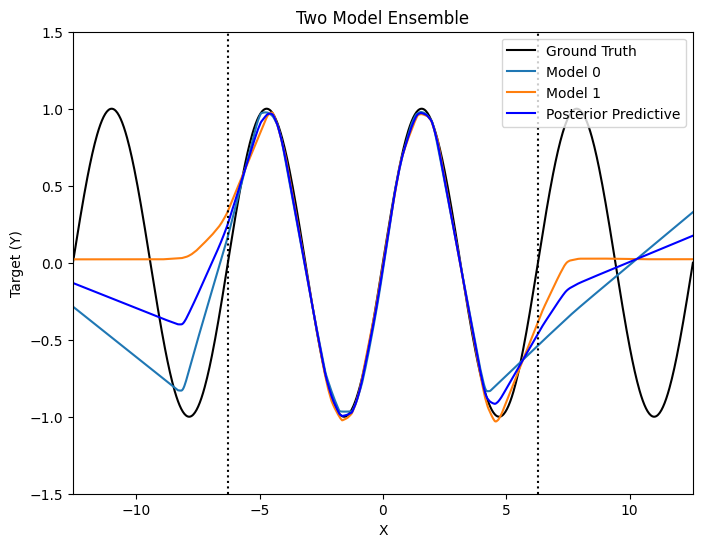

In [27]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_two_model_outputs[0], label="Model 0")
plt.plot(oos_xs, oos_two_model_outputs[1], label="Model 1")

plt.plot(oos_xs, oos_two_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)


plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


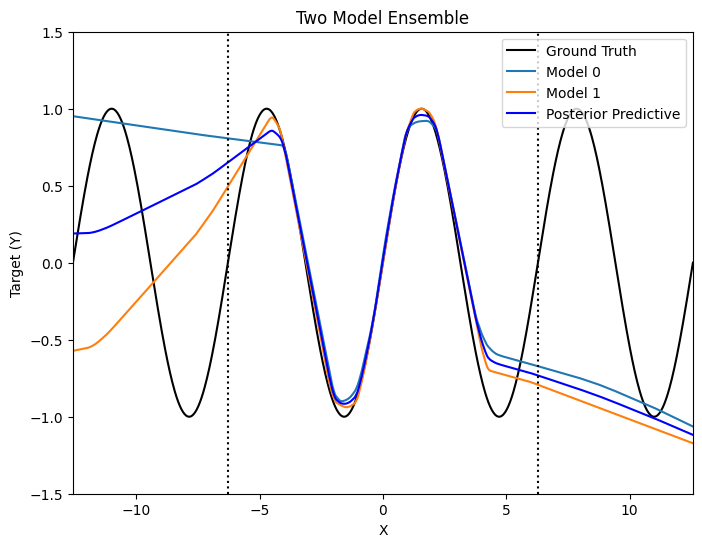

In [28]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_two_model_one_cache_outputs[0], label="Model 0")
plt.plot(oos_xs, oos_two_model_one_cache_outputs[1], label="Model 1")

plt.plot(oos_xs, oos_two_model_one_cache_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)


plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_two_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.fill_between(oos_x_flat, (np.array(oos_two_model_averages) - np.array(oos_two_model_var)).flatten(), (np.array(oos_two_model_averages) + np.array(oos_two_model_var)).flatten(), color='gray', alpha=1, label="Variance")



plt.ylim(-1.5, 1.5)
plt.title('Averaged Two Model Ensemble with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_four_model_outputs[0], label="Model 0")
plt.plot(oos_xs, oos_four_model_outputs[1], label="Model 1")
plt.plot(oos_xs, oos_four_model_outputs[2], label="Model 2")
plt.plot(oos_xs, oos_four_model_outputs[3], label="Model 3")
plt.plot(oos_xs, oos_four_model_averages, c="blue", label="Posterior Predictive")

plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.title('Four Model Ensemble Out of Sample')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, oos_four_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.fill_between(oos_x_flat, (np.array(oos_four_model_averages) - np.array(oos_four_model_var)).flatten(), (np.array(oos_four_model_averages) + np.array(oos_four_model_var)).flatten(), color='gray', alpha=1, label="Variance")
plt.ylim(-1.5, 1.5)
plt.title('Four Model Ensemble Out of Sample with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
for i in range(8):
    plt.plot(oos_xs, oos_eight_model_outputs[i], label=f"Model {i}")
    
plt.plot(oos_xs, oos_eight_model_averages, c="blue", label="Posterior Predictive")

plt.title('Eight Model Ensemble Out of Sample')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_eight_model_averages, c="blue", label="Posterior Predictive")
plt.fill_between(oos_x_flat, (np.array(oos_eight_model_averages) - np.array(oos_eight_model_var)).flatten(), (np.array(oos_eight_model_averages) + np.array(oos_eight_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.title('Averaged Eight Model Ensemble with Variance')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")

plt.plot(xs, sixteen_model_averages, c="blue", label="Posterior Predictive")
plt.xlim(train_begin_radians, train_end_radians)
plt.fill_between(x_flat, (np.array(sixteen_model_averages) - np.array(sixteen_model_var)).flatten(), (np.array(sixteen_model_averages) + np.array(sixteen_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.ylim(-1.5, 1.5)
plt.title('Averaged Sixteen Model Ensemble with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
for i in range(16):
    plt.plot(oos_xs, oos_sixteen_model_outputs[i], label=f"Model {i}")
    
plt.plot(oos_xs, oos_sixteen_model_averages, c="blue", label="Posterior Predictive")

plt.title('Sixteen Model Ensemble')  # Updated title
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_sixteen_model_averages, c="blue", label="Posterior Predictive")
plt.fill_between(oos_x_flat, (np.array(oos_sixteen_model_averages) - np.array(oos_sixteen_model_var)).flatten(), (np.array(oos_sixteen_model_averages) + np.array(oos_sixteen_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.title('Averaged Sixteen Model Ensemble with Variance')  # Updated title
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.